## Rx Gate
Sheet conducts the data collection exercise of to find the error rate of the Rx gate by rotation angle.

It does this using an IBM simulator loaded with a ibm_brisbane noise model.

The results get saved into a .csv for processing and plotting in the post_analysis.ipynb script'

Workbook assumes a folder structure to saver the data into and a TOKEN_DOC.py file in the root directory containing a TOKEN_STRING variable to talk with the IBM quantum server.

In [ ]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
import TOKEN_DOC

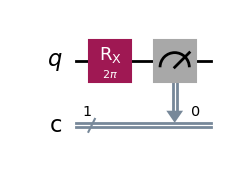

In [ ]:
# Function to create a circuit with an Rx gate
# rotate by 2*beta 
def create_rx_circuit(beta):
    qc = QuantumCircuit(1, 1)
    qc.rx(2*beta,0)
    qc.measure(0,0)
    return qc

# lets have a quick look at it to make sure it's working
qc= create_rx_circuit(beta=np.pi)
qc.draw("mpl")

### RX gate investigation

In [ ]:
# Define rotation angles to test
beta_values = np.pi*np.linspace(0, 0.5, 50)  # Test 50 angles between 0 and π
repeat_num = 5 #  number of initialisations to do (jobs)
shots = 2**16 # shots per initialisation

# load service
service = QiskitRuntimeService(channel="ibm_quantum",
                               token=TOKEN_DOC.TOKEN_STRING)

# Run simulations for each beta
simulator = AerSimulator.from_backend(service.backend("ibm_brisbane"))  # Noisy simulator
pm_noisy = generate_preset_pass_manager(optimization_level=1, backend=simulator)

# and run the experiment!
count = 0
run = True
if run:
    error_rates_repeated = []
    # loop over jobs
    for repeats in range(repeat_num):
        error_rates = []
        for beta in beta_values:
            # set up and run the circuit
            qc = create_rx_circuit(beta)
            isa_qc = pm_noisy.run(qc)
            sampler = Sampler(mode=simulator)
            result_noise = sampler.run([isa_qc], shots=shots).result()
            
            p_noisy = result_noise[0].data.c.get_counts().get("1", 0) / shots
            # know expected probability of P(1), see README for more details
            p_ideal = np.sin(beta) ** 2

            # find abs difference
            error = abs(p_noisy - p_ideal)

            # and collect
            error_rates.append(error)
        error_rates_repeated.append(error_rates)

### Now Save the collected data

In [ ]:
import pandas as pd

# loop through each angle
for i_beta, beta in enumerate(beta_values):
    err_values = [error_rates_repeated[i][i_beta] for i in range(len(error_rates_repeated))]
    # rotate by 2*beta
    single_angle_dict = {"angle":[2*beta]*len(err_values), "error_rate":err_values}

    # collect into a dataframe to save
    if i_beta == 0:
        output_df = pd.DataFrame(single_angle_dict)
    else:
        output_df = pd.concat([output_df, pd.DataFrame(single_angle_dict)])
        
output_df.reset_index(inplace=True, drop=True)
output_df.to_csv("data/2_processed/rx_investigation_results.csv", index=False)

Now can post process the results in post_analysis.ipynb